In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import transforms
from torch import nn
import torch.nn.functional as F
from torch import optim

%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', download=True, transform=transform, train=True)
test_data = datasets.MNIST(root='data', download=True, transform=transform, train=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
import torch

Train_Loader = torch.utils.data.DataLoader(train_data, batch_size=16)
Test_Loader = torch.utils.data.DataLoader(test_data, batch_size=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 15 + 1) instead
  after removing the cwd from sys.path.


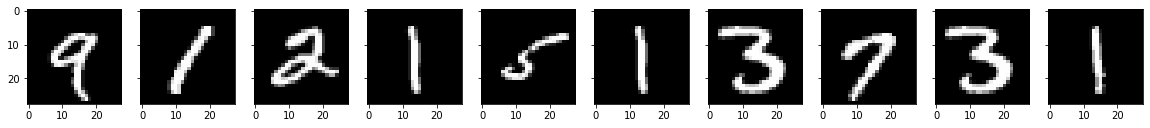

In [4]:
images, labels = next(iter(Train_Loader))

images = images.numpy()
inds = np.random.random_integers(0, 15, 10)

fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for i, axis in zip(inds, axes):
  axis.imshow(np.squeeze(images[i]), cmap='gray')

In [5]:
images[0].shape

(1, 28, 28)

In [6]:
if torch.cuda.is_available():
  train_on_gpu = True
  print("Training on GPU")
else:
  train_on_gpu = False
  print("Training on CPU")

Training on GPU


In [7]:
class Autoencoder(nn.Module):
  def __init__(self):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)
        
  def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)

        return x

model = Autoencoder()

if train_on_gpu:
  model.cuda()
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_fx = nn.MSELoss()

In [9]:
epochs = 300

for e in range(epochs):
  train_loss = 0.0
  for images, _ in Train_Loader:
    images = images.cuda()
    images = images.view(images.size(0), -1)

    optimizer.zero_grad()
    
    output = model(images)
    loss = loss_fx(images, output)
    loss.backward()

    optimizer.step()
    train_loss += loss.item() * images.size(0)

  train_loss = train_loss/len(Train_Loader)
  if(e % 10 == 0):
    print(f"Training loss after epoch {e} is {train_loss}")

Training loss after epoch 0 is 1.25803412454923
Training loss after epoch 10 is 0.6981140121380488
Training loss after epoch 20 is 0.4986779453357061
Training loss after epoch 30 is 0.40825511813958487
Training loss after epoch 40 is 0.34677280737559
Training loss after epoch 50 is 0.30752160905996956
Training loss after epoch 60 is 0.27956213761170706
Training loss after epoch 70 is 0.25941272290945055
Training loss after epoch 80 is 0.2449783499399821
Training loss after epoch 90 is 0.23306420597632727
Training loss after epoch 100 is 0.22155561665693918
Training loss after epoch 110 is 0.21085019178787867
Training loss after epoch 120 is 0.2018485747496287
Training loss after epoch 130 is 0.1941920830130577
Training loss after epoch 140 is 0.18772829958796503
Training loss after epoch 150 is 0.18199684728185336
Training loss after epoch 160 is 0.176979746089379
Training loss after epoch 170 is 0.17257275480826695
Training loss after epoch 180 is 0.16866798506975175
Training loss aft

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 15 + 1) instead
  from ipykernel import kernelapp as app


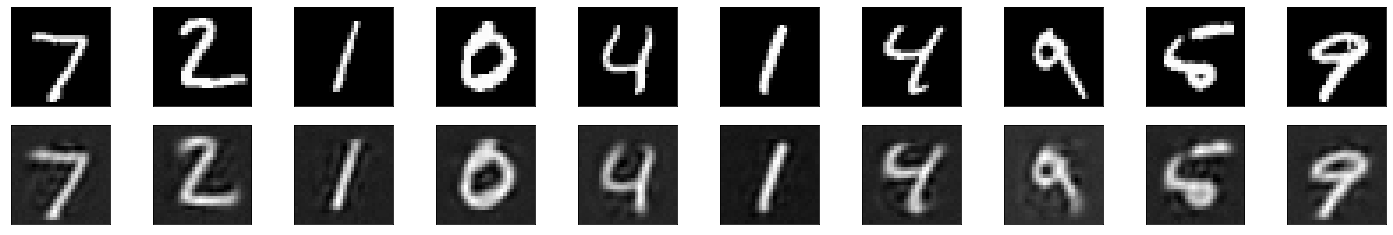

In [10]:
images, labels = next(iter(Test_Loader))

#model.eval()
flat_images = images.view(images.size(0), -1)
flat_images = images.cuda()

generated_img = model(flat_images)

generated_img = generated_img.view(16, 1, 28, 28)

generated_img = generated_img.cpu()
generated_img = generated_img.detach().numpy()

images = images.numpy()
inds = np.random.random_integers(0, 15, 10)

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, generated_img], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)